In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import model_zoo
import data_freiburg_numpy_to_hdf5
from utils import make_dir_safely
from scipy.special import softmax
import h5py

from losses import compute_dice

## Using model

In [3]:
# load saved model
loss = "dice"
out_channels = 2
in_channels = 4
run = 1
note = '_full_run_bern_full'
cut_z = True # True/3
da = 0.0
model_path = f'/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/CNN-segmentation/logdir/unet3d_da_{da}nchannels{in_channels}_r{run}_loss_{loss}_cut_z_{cut_z}{note}'
#model_path = f'/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/CNN-segmentation/logdir/unet3d_da_{da}nchannels{in_channels}_r_phase_dice_cut_z_5_debug'
#model_path = "/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/CNN-segmentation/logdir/unet3d_da_0.0nchannels1_r_DEBUG_LOSS_phase_dice_cut_z_0"
best_model_path = os.path.join(model_path, list(filter(lambda x: 'best' in x, os.listdir(model_path)))[-1])
print(best_model_path)
model = model_zoo.UNet(in_channels, out_channels)
model.load_state_dict(torch.load(best_model_path, map_location=torch.device('cpu')));
model.eval();

/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/CNN-segmentation/logdir/unet3d_da_0.0nchannels4_r1_loss_dice_cut_z_True_full_run_bern_full/model_best_100_step_9000.pth


In [5]:
# Bern data
# This has already done Bern_numpy_to_hdf5.py
basepath = "/usr/bmicnas02/data-biwi-01/jeremy_students/data/inselspital/kady"
bern_tr = h5py.File(basepath + '/bern_images_and_labels_from_101_to_104.hdf5','r')
bern_vl = h5py.File(basepath + '/bern_images_and_labels_from_105_to_106.hdf5','r')
images_tr = bern_tr['images_train'][:]
labels_tr = bern_tr['labels_train'][:]
images_vl = bern_vl['images_validation'][:]
labels_vl = bern_vl['labels_validation'][:]        

In [6]:
if cut_z != False:
    keep_indices_tr = np.where(bern_tr['alias'][:] ==0)[0]
    keep_indices_vl = np.where(bern_vl['alias'][:] ==0)[0]
    images_tr = images_tr[keep_indices_tr]
    labels_tr = labels_tr[keep_indices_tr]
    images_vl = images_vl[keep_indices_vl]
    labels_vl = labels_vl[keep_indices_vl]

In [7]:
images_tr.shape, labels_tr.shape, images_vl.shape, labels_vl.shape#, images_test.shape, labels_test.shape

((200, 144, 112, 48, 4),
 (200, 144, 112, 48),
 (92, 144, 112, 48, 4),
 (92, 144, 112, 48))

### Compute dice loss

In [ ]:
def iterate_minibatches_validation(images, labels, batch_size):
    """
    Function to create mini batches from the dataset of a certain batch size
    :param images: input images
    :param labels: labels
    :param batch_size: batch size
    :return: mini batches"""
    assert len(images) == len(labels)
    
    # Generate randomly selected slices in each minibatch

    n_images = images.shape[0]
    random_indices = np.arange(n_images)
    np.random.shuffle(random_indices)

    # Use only fraction of the batches in each epoch

    for b_i in range(0, n_images, batch_size):

        if b_i + batch_size > n_images:
            continue


        # HDF5 requires indices to be in increasing order
        batch_indices = np.sort(random_indices[b_i:b_i+batch_size])

        X = images[batch_indices, ...]
        y = labels[batch_indices, ...]
        
        # ===========================
        # check if the velocity fields are to be used for the segmentation...
        # ===========================
        if in_channels == 1:
            X = X[..., 1:2]
        
        yield X, y


In [ ]:
def dice_score(images_set, labels_set, batch_size = 4):
        dice_score = 0
        for n_batch, batch in enumerate(iterate_minibatches_validation(images_set, labels_set, batch_size = batch_size)):
                model.eval()
                with torch.no_grad():
                        inputs, labels = batch
                
                        # From numpy.ndarray to tensors
                
                        # Input (batch_size, x,y,t,channel_number)
                        inputs = torch.from_numpy(inputs)
                        # Input (batch_size, channell,x,y,t)
                        inputs.transpose_(1,4).transpose_(2,4).transpose_(3,4)
                        # Labels (batch,size, x,y,t)
                
                        #inputs = inputs.to(device)
                        labels = torch.from_numpy(labels)#.to(device)
                        labels = torch.nn.functional.one_hot(labels.long(), num_classes = out_channels)
                        labels = labels.transpose(1,4).transpose(2,4).transpose(3,4)
                        
                        
                        logits = model(inputs.float())
                        
                        _, mean_dice,_= compute_dice(logits, labels)
                        
                        dice_score += mean_dice  
        return dice_score, n_batch
        

In [ ]:
print("Training dice")
dice_score_tr, n_batch_tr = dice_score(images_tr, labels_tr, batch_size = 2)
print("Total average dice score: ", dice_score_tr/(n_batch_tr+1))

In [ ]:
print("Validation dice")
dice_score_vl, n_batch_vl = dice_score(images_vl, labels_vl, batch_size = 2)
print("Total average dice score: ", dice_score_vl/(n_batch_vl+1))

In [ ]:
print("Testing dice")
dice_score_test, n_batch_test = dice_score(images_test, labels_test, batch_size = 2)
print("Total average dice score: ", dice_score_test/(n_batch_test+1))

In [8]:
batch_size = 16
np.random.seed(0)
inputs = images_vl[np.sort(np.random.randint(len(images_vl), size = batch_size))]
np.random.seed(0)
labels = labels_vl[np.sort(np.random.randint(len(images_vl), size = batch_size))]

inputs = torch.from_numpy(inputs)
# Input (batch_size, channell,x,y,z)
inputs.transpose_(1,4).transpose_(2,4).transpose_(3,4)
labels = torch.from_numpy(labels)

In [9]:
inputs.shape, labels.shape

(torch.Size([16, 4, 144, 112, 48]), torch.Size([16, 144, 112, 48]))

In [10]:
%reset_selective -f preds

In [11]:
preds = np.array([]).reshape(0, 2,144, 112,48)
for i in range(batch_size):
    model.eval()
    with torch.no_grad():
        pred = model(inputs[i*batch_size//8:(i+1)*batch_size//8])
        preds = np.vstack([preds, pred.detach().numpy()])

In [12]:
labels.shape

torch.Size([16, 144, 112, 48])

In [13]:

prediction = softmax(preds, axis=1).argmax(axis = 1)

In [14]:
%matplotlib inline
def plot_time(t = 0):
    fig, axs = plt.subplots(4,4);
    img = 0
    for i, ax in enumerate(axs.reshape(-1)):
        
        if i%2 == 0:
            ax.imshow(prediction[img,:,:,t])
            

        else:
            ax.imshow(labels[img,:,:,t])   
            img = img + 1 
        print(img)
    plt.show()

0
1
1
2
2
3
3
4
4
5
5
6
6
7
7
8


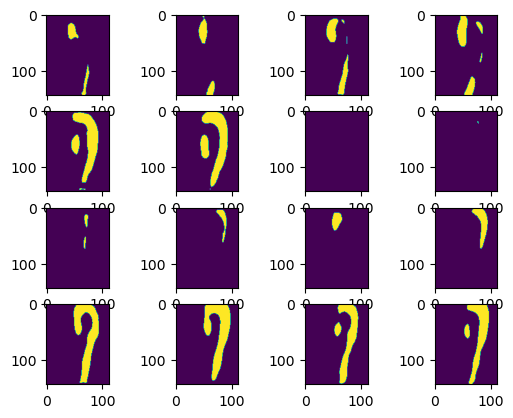

In [15]:
plot_time(0)

## Visualization the outputs


In [16]:
viz_on = "validation" # training/validation
model_path

'/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/CNN-segmentation/logdir/unet3d_da_0.0nchannels4_r1_loss_dice_cut_z_True_full_run_bern_full'

In [17]:
best_model_path

'/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/CNN-segmentation/logdir/unet3d_da_0.0nchannels4_r1_loss_dice_cut_z_True_full_run_bern_full/model_best_100_step_9000.pth'

In [18]:
list_files = os.listdir(model_path + f'/results/visualization/{viz_on}/')
image_number = 10
list_files[:8]

['step_0_pred_image_0.npy',
 'step_0_true_image_0.npy',
 'step_0_input_image_0.npy',
 'step_0_pred_image_10.npy',
 'step_0_true_image_10.npy',
 'step_0_input_image_10.npy',
 'step_0_pred_image_20.npy',
 'step_0_true_image_20.npy']

In [19]:
image_filter = list(filter(lambda x: f'_image_{image_number}' in x, list_files))
image_filter[-5:]

['step_10800_true_image_10.npy',
 'step_10800_input_image_10.npy',
 'step_11200_pred_image_10.npy',
 'step_11200_true_image_10.npy',
 'step_11200_input_image_10.npy']

In [22]:
image_filter = list(filter(lambda x: f'_image_{image_number}' in x, list_files))

TypeError: join() argument must be str, bytes, or os.PathLike object, not 'list'

In [23]:
# Check for best model STEP
step = 9200
pred = np.load(os.path.join(model_path,f'results/visualization/{viz_on}', list(filter(lambda x: f'_{step}' in x, image_filter))[0]))
gt = np.load(os.path.join(model_path,f'results/visualization/{viz_on}', list(filter(lambda x: f'_{step}' in x, image_filter))[1]))
input = np.load(os.path.join(model_path,f'results/visualization/{viz_on}', list(filter(lambda x: f'_{step}' in x, image_filter))[2]))
np.where(gt ==1), np.where(pred ==1)


((array([0, 0, 0, ..., 5, 5, 5]),
  array([ 37,  37,  37, ..., 143, 143, 143]),
  array([52, 52, 52, ..., 65, 65, 65]),
  array([21, 22, 23, ..., 22, 23, 24])),
 (array([0, 0, 0, ..., 6, 6, 6]),
  array([40, 40, 40, ..., 14, 14, 14]),
  array([49, 49, 49, ..., 68, 68, 68]),
  array([ 3,  4,  5, ..., 18, 19, 20])))

In [24]:
%matplotlib inline
def plot_batches(array, input_image = False):

    time_slice = 20
    if input_image:
        fig, axs = plt.subplots(2, 4, figsize=(6,6))
        for n, ax in enumerate(axs.reshape(-1)):
            ax.imshow(array[n,0,:,:,time_slice])
        plt.show()
    else:
        fig, axs = plt.subplots(2, 4, figsize=(6,6))
        for n, ax in enumerate(axs.reshape(-1)):
            ax.imshow(array[n,:,:,time_slice])
        plt.show()

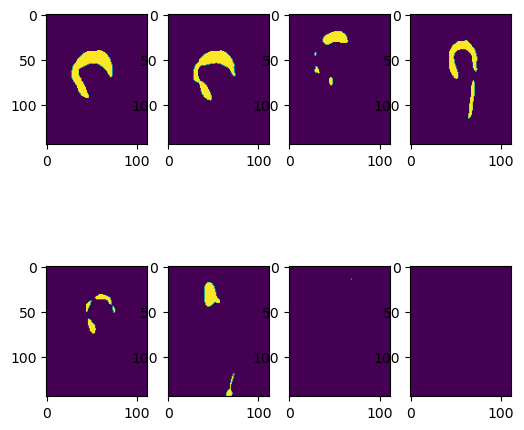

In [25]:
plot_batches(pred)

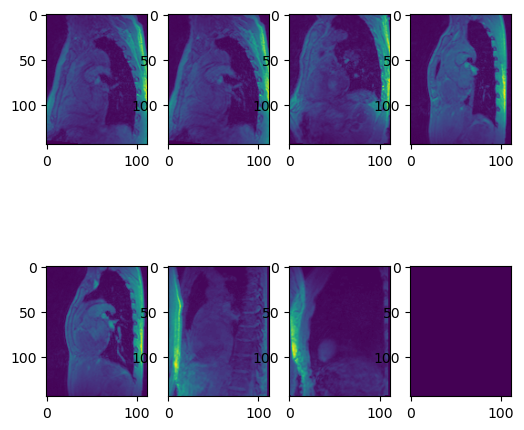

In [26]:
plot_batches(input, input_image = True)

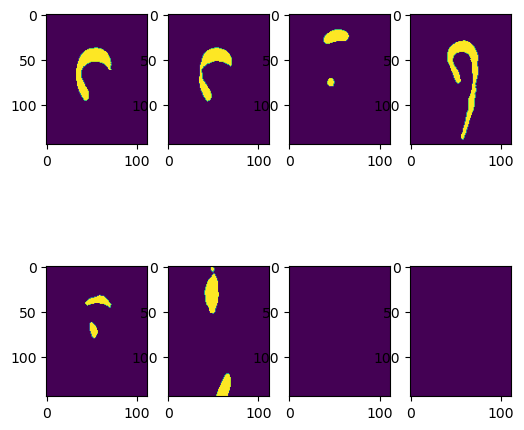

In [27]:
plot_batches(gt)

In [28]:
gt.shape, input.shape, pred.shape


((8, 144, 112, 48), (8, 4, 144, 112, 48), (8, 144, 112, 48))

In [29]:
%matplotlib inline
def presentation_viz(input, gt, pred, time, save_path, n_channels = 4, batch = 8):
    # Create directory if it does not exist
    make_dir_safely(save_path)
    if n_channels == 4:
        h = 18
    else:
        h = 7
    
    fig, axs = plt.subplots(2+n_channels, batch, figsize = (18,h))
    nbatch = 0
    n_chan = n_channels
    ax = axs.reshape(-1)
    axes_index = 0
    for chan in range(n_channels):
        
        for i in range(batch):
            
            ax[axes_index].imshow(input[i, n_channels - n_chan, :, :, time])
            ax[axes_index].set_title(f"n_{i}_ch:{n_channels - n_chan}_t_{time}", fontsize = 10)
            axes_index += 1
        n_chan -= 1
    for i in range(batch):
        ax[axes_index].imshow(pred[i, :,:, time])
        ax[axes_index].set_title(f"n_{i}_pred_t_{time}", fontsize = 10)
        axes_index +=1
    for i in range(batch):
        ax[axes_index].imshow(gt[i, :,:, time])
        ax[axes_index].set_title(f"n_{i}_gt_t_{time}", fontsize = 10)
        axes_index +=1
    plt.savefig(os.path.join(save_path, f"random_batch_t_{time}.png"), bbox_inches='tight')
    plt.show()
    
        

In [30]:
save_viz = model_path + f"/results/visualization/notebook_viz/{viz_on}"

In [31]:
save_viz

'/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/CNN-segmentation/logdir/unet3d_da_0.0nchannels4_r1_loss_dice_cut_z_True_full_run_bern_full/results/visualization/notebook_viz/validation'

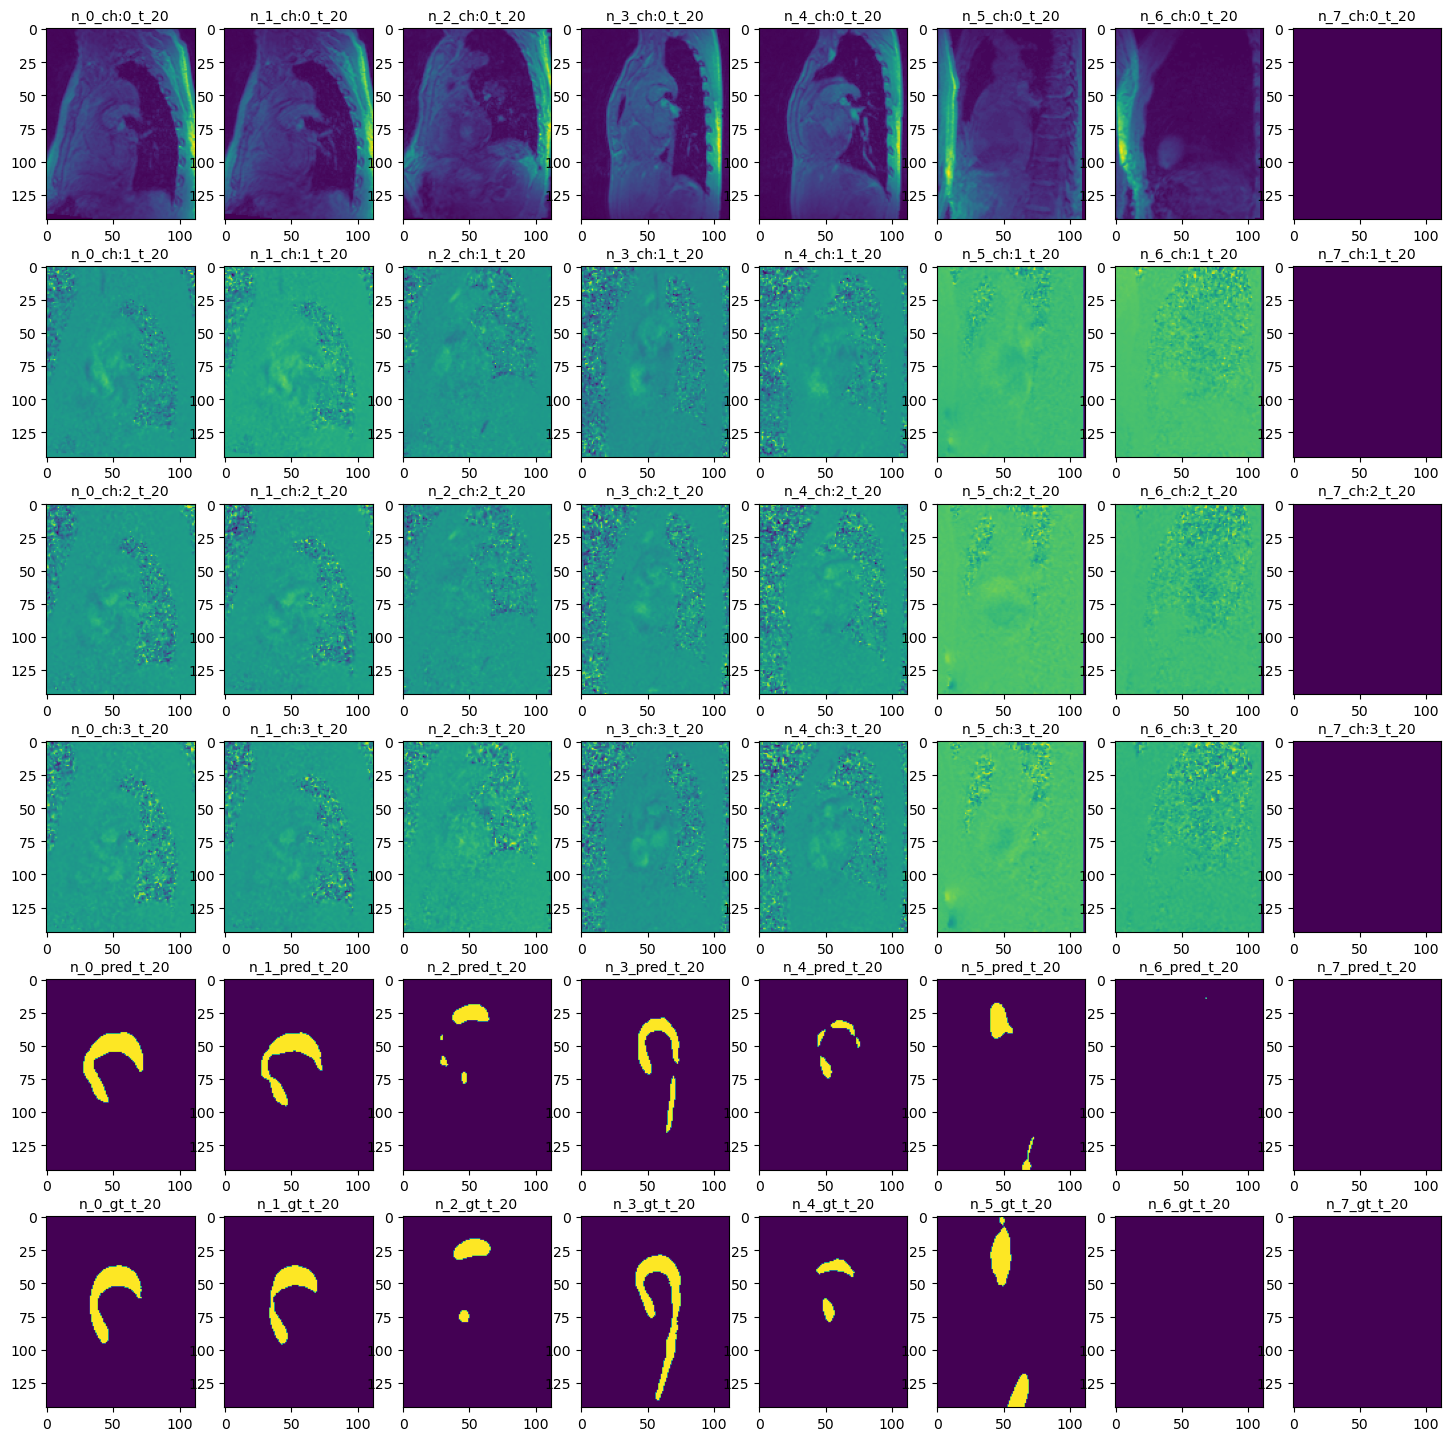

: 

In [36]:
presentation_viz(input, gt, pred, time = 20, save_path= save_viz, n_channels = in_channels)

## Visualizing the inputs


In [33]:
try:
    debug_in = np.load(model_path + "/inputs_train_batch.npy")
    debug_label = np.load(model_path + "/labels_train_batch.npy")
    slice_ = 0
    print(slice_)
    %matplotlib inline
    plt.imshow(debug_in[slice_, :,:, 3,1])
    plt.show()
    plt.imshow(debug_in[slice_, :,:, 3,0])
    plt.imshow(debug_label[slice_, :,:, 3], alpha= 0.1)
    slice_ +=1 
    plt.show()
except:
    pass